In [1]:
import torch
import torch.nn as nn 
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()

LOAD DATA

In [2]:
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x), data_transforms[x])
                    for x in ['train','val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
                    for x in ['train', 'val']}

dataset_sizes = {x:len(image_datasets[x]) for x in ['train','val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cpu')

VISUALIZE SOME IMAGES

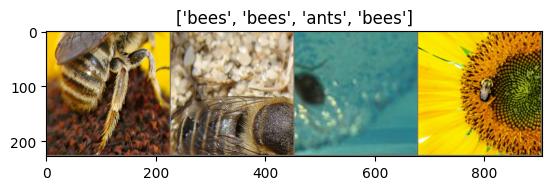

In [4]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# get a bunch of training data
inputs, classes = next(iter(dataloaders['train']))

# make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

TRAINING THE MODEL

write a generic function to train a model

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 2}")
        print("-" * 10)

        # each epoch has a training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                model.train()   # set model to training mode
            else:
                model.eval()    # set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward 
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)   
                    _, preds = torch.max(outputs,1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc: {best_acc:.4f}")

    # loas best model weights
    model.load_state_dict(best_model_wts)
    return model
            

VISUALIZING THE MODEL PREDICTIONS
function to display predictions for a few images

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs,1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f"Predicted: {class_names[preds[j]]}")
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


FINETUNING THE CONVNET

load a pretrained model and reset the final fully connected layer

In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# set the size of each output sample to the number of classes
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr = 0.001, momentum=0.9)

# decay the learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

C:\data\transfer_learning\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\data\transfer_learning\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


TRAIN AND EVALUATE      

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/23
----------
train Loss: 0.6744 Acc: 0.6189
val Loss: 0.2249 Acc: 0.9020

Epoch 1/23
----------
train Loss: 0.4393 Acc: 0.8238
val Loss: 0.2955 Acc: 0.8889

Epoch 2/23
----------
train Loss: 0.5535 Acc: 0.7869
val Loss: 0.3250 Acc: 0.8693

Epoch 3/23
----------
train Loss: 0.4549 Acc: 0.8074
val Loss: 0.2999 Acc: 0.9150

Epoch 4/23
----------
train Loss: 0.5102 Acc: 0.8156
val Loss: 0.4064 Acc: 0.8758

Epoch 5/23
----------
train Loss: 0.3640 Acc: 0.8443
val Loss: 0.3283 Acc: 0.8824

Epoch 6/23
----------
train Loss: 0.3750 Acc: 0.8689
val Loss: 0.2841 Acc: 0.8824

Epoch 7/23
----------
train Loss: 0.3412 Acc: 0.8525
val Loss: 0.2438 Acc: 0.8954

Epoch 8/23
----------
train Loss: 0.3019 Acc: 0.8730
val Loss: 0.2138 Acc: 0.9216

Epoch 9/23
----------
train Loss: 0.3105 Acc: 0.8443
val Loss: 0.2504 Acc: 0.9020

Epoch 10/23
----------
train Loss: 0.2931 Acc: 0.8852
val Loss: 0.2464 Acc: 0.9150

Epoch 11/23
----------
train Loss: 0.3008 Acc: 0.8730
val Loss: 0.2411 Acc: 0.9150

Ep